In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
BATCH_SIZE = 16

In [3]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [4]:
imdb_data=pd.read_csv('./data/processed_train.csv')
print(imdb_data.shape)
imdb_data.head(5)

(29341, 4)


,ID,review,sentiment,processed_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...


In [5]:
imdb_test_data=pd.read_csv('./data/processed_test.csv')
print(imdb_test_data.shape)
imdb_test_data.head(5)

(29341, 3)


,ID,review,processed_review
0,22622,Robert Lansing plays a scientist experimenting...,robert lansing play scientist experiment pass ...
1,10162,"Well I've enjoy this movie, even though someti...",ve enjoy movie turn stereotypical situation nt...
2,17468,First things first - though I believe Joel Sch...,thing believe joel schumacher well mediocre di...
3,42579,I watched this movie on the grounds that Amber...,watch movie ground amber benson rock nick stah...
4,701,A certain sexiness underlines even the dullest...,certain sexiness underline dull tangent


In [6]:
%%time
# Concatenate train data and test data
all_review = list(map(str, np.concatenate([imdb_data.processed_review.values, imdb_test_data.processed_review.values])))

Wall time: 13 ms


### Choose MAX_LENGTH for BERT

In [7]:
token_lens = []

for txt in tqdm(all_review):
    # handle not vaild input issue
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 58682/58682 [02:24<00:00, 407.14it/s]


Text(0, 0.5, 'Density')

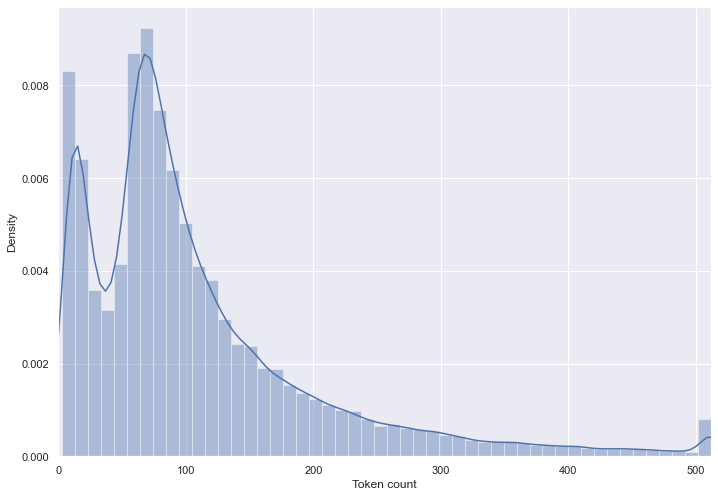

In [8]:
# plot distribution of length 
sns.distplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Token count')
plt.ylabel('Density')

In [8]:
MAX_LEN = 512

In [9]:
len(imdb_data.loc[870,'processed_review'])

372

In [10]:
encoded_sent = tokenizer.encode_plus(
    text=imdb_data.loc[870,'processed_review'],  # Preprocess sentence
    add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
    max_length=MAX_LEN,                  # Max length to truncate/pad
    padding=True,         # Pad sentence to max length
    return_tensors='pt',           # Return PyTorch tensor
    return_attention_mask=True      # Return attention mask
    )

print(encoded_sent.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [11]:
print(encoded_sent['input_ids'])
print(encoded_sent['token_type_ids'])
print(encoded_sent['attention_mask'])

tensor([[  101,  3185,  2941,  6057,  1040,  2066,  2717,  4167,  3178,  3805,
          3422,  1055,  2655,  9081,  8855,  2123,  5987, 13769, 15902,  8257,
          3185,  5959, 12991, 13874,  9081,  1055,  6057,  3185,  3422,  3058,
          2194,  2767,  2926, 17358,  8840,  2140, 17217, 15339,  3492,  2980,
         14556,  1055,  6707,  3648,  3185,  3538,  2396,  1039, 12256,  3185,
          9081,  1055,  6814,  2422,  6057, 23105,  2518,  2228,  2611,  9120,
          2066,  3185,  3124,  5791,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


### Define Dataset & DataLoader

In [12]:
class IMDB_Dataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index] # get item via index like list
        target = self.targets[index]
        
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=review,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding=True,         # Pad sentence to max length
            return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        return {
            'review_text' : review,
            'input_ids' : encoded_sent['input_ids'].flatten(),
            'attention_mask' : encoded_sent['attention_mask'].flatten(),
            'targets' : torch.tensor(target, dtype=torch.long)
        }

In [13]:
train_df, val_df = train_test_split(imdb_data, test_size=0.2, random_state=75)
print(train_df.shape, val_df.shape)

(23472, 4) (5869, 4)


In [14]:
train_dataset = IMDB_Dataset(train_df.processed_review, train_df.sentiment, tokenizer, MAX_LEN)
val_dataset = IMDB_Dataset(val_df.processed_review, val_df.sentiment, tokenizer, MAX_LEN)

In [15]:
train_dataset[1]

{'review_text': 'movie manage lot people see place bump accident judging review rating enjoy usually tolerate gere look charm consider great actor know crazy pretty like mr jones performance different pretty charming character completely different see point old ugly break determine gere far good performance pull beautifully guess sign actor job imagine instead think hopkins hannibal lecter washington alonzo training day good gere rest cast fine guess cast dane role think good look actually excellent job hold gere form small feat strickland easily deliver good support act require considerable range actually think own key scene gere danes achievement rest movie apart excellent act story hugely surprising 8 mm ish aspect add veteran break rookie storyline dunnit like silence lamb add sense urgency try save girl impend retirement gere s character backdrop development main character help settle respective new station life s lot accomplish 100 minute end care character happen direction photo

In [16]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0)))
print(sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape)

KeyError: 3

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)

Downloading: 100%|██████████| 570/570 [00:00<00:00, 95.2kB/s]
Downloading: 100%|██████████| 436M/436M [01:50<00:00, 3.93MB/s]
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
all_review[15]

'inept big screen remake avenger wild wild west'

In [7]:
%%time

# Encode our concatenated data
encoded_review = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_review]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_review])
print('Max length: ', max_len)

ValueError: Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)